# 📝 A Review Of Backend Engineering Jobs (as of Nov 18 2025)

This notebook uses [a pre-existing tool](https://github.com/speedyapply/JobSpy) to scrape the most recent backend engineering jobs from areas adjacent to major cities across the US, covering as much state as possible. The choice of cities is somewhat arbitrary. It has 3060 jobs from the past months, each job has the following attributes:

- title
- location
- area
- company
- date posted
- job type
- is remote
- job level
- job function
- description

The city and state name used to search for jobs is added as the `area` of jobs. It could be different from the exact location of the job. 

**Notes 0.1**: there were more jobs on the market, but the scrapper only scanned the some of the jobs. I didn't read in depth how the scrapper decide which job to keep.  
**Notes 0.2**: to verify the data aggregation pipeline and a list of cities covered in the dataset, check appendix at the end of the notebook.   
**Notes 0.3**: all data are available on Kaggle: [**view and download**](https://www.kaggle.com/datasets/tianyimasf/backend-engineer-jobs-us/data)

## 🔍 Exploratory Data Analysis

For this analysis, I only scraped jobs from LinkedIn. Indeed is weird to use and Google Job's data is usually dirty, and the jobs postings have a lot of overlaps anyways. 

From a first glance, we can see that there're a lot of null values in a lot of the fields. But if you look at the field names closely, most of the fields are not that important anyways. It's good to know them if exists, but not necessary to get a snapshot of what kind of backend engineering jobs are out there and what they require.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
root_dir = "data/"
job_dir_backend_eng = "backend_engineer/"
job_dir_ds = "data_scientist/"

In [3]:
jobs = pd.read_csv(root_dir+"jobs.csv")
jobs.head()

,id,site,job_url,job_url_direct,title,company,location,area,date_posted,job_type,...,company_addresses,company_num_employees,company_revenue,company_description,skills,experience_range,company_rating,company_reviews_count,vacancy_count,work_from_home_type
0,li-4323516725,linkedin,https://www.linkedin.com/jobs/view/4323516725,NaN,Junior Software Engineer,Brooksource,"Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,li-4333159993,linkedin,https://www.linkedin.com/jobs/view/4333159993,https://shipt.wd1.myworkdayjobs.com/Shipt_Exte...,Senior Engineer,Shipt,"Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,li-4256077277,linkedin,https://www.linkedin.com/jobs/view/4256077277,https://industrycareers-enercon.icims.com/jobs...,Physical Security Engineer,"Enercon Services, Inc.","Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,li-4338291784,linkedin,https://www.linkedin.com/jobs/view/4338291784,NaN,Distinguished Engineer - AI Infrastructure Arc...,Cisco,"Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,li-4302046287,linkedin,https://www.linkedin.com/jobs/view/4302046287,NaN,Information Services Quality Assurance Interns...,Altec,"Birmingham, AL","Birmingham, AL",2025-11-21,internship,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
jobs.shape

(3060, 35)

I always use `{dfname}.info()` after `{dfname}.head()`. `{dfname}.head()` gives me a general sense, but `{dfname}.info()` gives me signals on which of the fields are actually useful. In this instance, most of the fields that I expect to have values, like `title`, `company`, `description`, `company_industry` are all filled with values. A couple is lacking some values like `location` and `date_posted`. Since I didn't build the scraper, I don't know why they're lacking. It could be crucial, but since the amount of values lacking are not a lot and we supposedly already know the range, it seems fine for me to leave it as is. Sometimes null values like this could reveal crucial problems in the system if this analysis is for business purposes, but that's not the case here. 

The other thing is a few fields don't have all the values but some, like `job_url_direct`, `emails`, `salary_source`, `interval`, `min_amount`, `max_amount` and `currency`. We won't be analyzing all of these fields in this notebook, but it's interesting to see, for example, 898 out of the 3060 jobs have direct link to their job postings and 573 out of the 3060 jobs have emails. Only 143 out of all jobs have salary ranges, which we'll do some light analysis on later.

In [5]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3060 non-null   object 
 1   site                   3060 non-null   object 
 2   job_url                3060 non-null   object 
 3   job_url_direct         898 non-null    object 
 4   title                  3060 non-null   object 
 5   company                3060 non-null   object 
 6   location               2903 non-null   object 
 7   area                   3060 non-null   object 
 8   date_posted            2607 non-null   object 
 9   job_type               3060 non-null   object 
 10  salary_source          143 non-null    object 
 11  interval               143 non-null    object 
 12  min_amount             143 non-null    float64
 13  max_amount             143 non-null    float64
 14  currency               143 non-null    object 
 15  is_r

In [6]:
jobs.columns

Index(['id', 'site', 'job_url', 'job_url_direct', 'title', 'company',
       'location', 'area', 'date_posted', 'job_type', 'salary_source',
       'interval', 'min_amount', 'max_amount', 'currency', 'is_remote',
       'job_level', 'job_function', 'listing_type', 'emails', 'description',
       'company_industry', 'company_url', 'company_logo', 'company_url_direct',
       'company_addresses', 'company_num_employees', 'company_revenue',
       'company_description', 'skills', 'experience_range', 'company_rating',
       'company_reviews_count', 'vacancy_count', 'work_from_home_type'],
      dtype='object')

### 📌 Map of jobs counts of cities across the US

In [7]:
import plotly.express as px
import plotly.io as pio
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

Convert each (city, state) to latitude and longitude to locate in the US map.

In [8]:
'''
area_counts = jobs.groupby("area").size().reset_index(name="count")

geolocator = Nominatim(user_agent="job_mapper", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

lat_list = []
lon_list = []

for area in area_counts["area"]:
    loc = geocode(f"{area}, USA")
    if loc:
        lat_list.append(loc.latitude)
        lon_list.append(loc.longitude)
    else:
        lat_list.append(None)
        lon_list.append(None)
    time.sleep(1)  # required to avoid rate-limit

area_counts["lat"] = lat_list
area_counts["lon"] = lon_list
'''

'\narea_counts = jobs.groupby("area").size().reset_index(name="count")\n\ngeolocator = Nominatim(user_agent="job_mapper", timeout=10)\ngeocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)\n\nlat_list = []\nlon_list = []\n\nfor area in area_counts["area"]:\n    loc = geocode(f"{area}, USA")\n    if loc:\n        lat_list.append(loc.latitude)\n        lon_list.append(loc.longitude)\n    else:\n        lat_list.append(None)\n        lon_list.append(None)\n    time.sleep(1)  # required to avoid rate-limit\n\narea_counts["lat"] = lat_list\narea_counts["lon"] = lon_list\n'

In [9]:
area_counts = pd.read_csv(root_dir+"area2latlon.csv")

fig = px.scatter_geo(
    area_counts,
    lat="lat",
    lon="lon",
    size="count",
    hover_name="area",
    hover_data={"count": True},
    size_max=50,
    opacity=0.7,
    color="count",
    color_continuous_scale="Viridis",
    projection="albers usa",
)

# Balanced background and black state lines
fig.update_layout(
    title="Job Counts By City Across The US",
    title_font_size=20,
    title_font_color="#555555",   # grey title
    geo=dict(
        scope="usa",
        showland=True,
        landcolor="#e0e0e0",        # medium-light gray
        lakecolor="#d0e8ff",        # pale blue lakes
        showlakes=True,
        showcountries=True,
        countrycolor="gray",
        showcoastlines=False,
        bgcolor="#f5f5f5",           # soft gray background
        showsubunits=True,
        subunitcolor="gray",         # black state lines
    ),
    paper_bgcolor="#f5f5f5",         # soft gray outside map
    font=dict(color="black"),
    margin={"r":0,"t":50,"l":0,"b":0},
    height=400,
    width=700,
)

# Optional: add city labels
fig.update_traces(text=area_counts["area"], textposition="top center")
fig.write_html("job_counts_by_city_us.html", full_html=False, include_plotlyjs='cdn')

fig.show()

In [10]:
fig = px.treemap(
    area_counts,
    path=["area"],          # Each rectangle = area
    values="count",         # Rectangle size = job count
    color="count",          # Color by job count
    color_continuous_scale="Viridis",  # Pretty gradient
    hover_data={"count": True},
)

# Layout improvements
fig.update_layout(
    title="Ratio of Jobs Counts Per City Across The US",
    title_font_size=22,
    margin=dict(t=50, l=25, r=25, b=25),
    height=500,
    width=700,
)

# Optional: customize text
fig.update_traces(
    texttemplate="%{label}\n%{value}",  # show area + count inside each rectangle
    textfont_size=14
)

fig.write_html("ratio_of_job_counts_by_city.html", full_html=False, include_plotlyjs='cdn')
fig.show()

Each city's job data is manually scraped using [an existing scraping API](https://github.com/speedyapply/JobSpy), so it's black box why the scraper found the resulting number of jobs. The number is correlated with our impression of which city has more tech jobs, but there's no way, for example, Boston, SF and Denver all have exactly 140 jobs at the time it's being scraped. 

In any way, there're more jobs in commonly-known tech hubs like San Francisco and San Jose, CA (= 140). But there are also a lot of backend engineering jobs in big cities like Baltimore, Washington DC and Chicago. It might be expected that Southern state have fewer jobs, but it's good to see that these following cities also have a decent amount of jobs:

- Atlanta, GA
- Raleigh, NC
- Charlotte, NC
- Detroit, MI (80)
- Minneapolis, MN (75)
- Cincinnati, OH (70)
- Phoenix, AZ (70)
- Salt Lake City, UT (70)
- Hartford, CT (70)
- Pittsburgh, PA (69)

Especially Atlanta, GA has 120 jobs, Raleigh and Charlotte from North Carolina have 90 and 89 jobs found respectively. For comparison, Hartford, CT also have 70 jobs and Hartford is one of the small cities that has a lot of very well-paid tech jobs right above the NY state.

Lastly, it seems from the US map of job counts by city that the majority of the jobs are from big tech cities. However, breaking it down in the second box/proportion graph, it's obvious that the number of jobs from big tech cities is clearly below the total number of jobs in the dataset. Moreover, there's a significant representation of cities from red states in the rest of the dataset, demonstrated by the city names in most of the boxes on the right side of the plot. 

## 💵 Salary

Since `salary` field only has 42 values, it's convenient to analyze that and just get it out of the way.

In [11]:
salary_source = jobs.salary_source.dropna().tolist()
intervals = jobs.interval.dropna().tolist()
min_amount = jobs.min_amount.dropna().tolist()
max_amount = jobs.max_amount.dropna().tolist()
print("First value of each related field \n"+
f"salary_source: \"{salary_source[0]}\" \ninterval: {intervals[0]} \nmin_amount: {min_amount[0]} \nmax_amount: {max_amount[0]}")

First value of each related field 
salary_source: "description" 
interval: yearly 
min_amount: 90000.0 
max_amount: 110000.0


From experience `salary_source` and `interval` would be the same for each of the 42 row. Just for scientific spirits, let's verify that.

In [12]:
salary_source_unique = jobs.salary_source.dropna().unique().tolist()
intervals_unique = jobs.interval.dropna().unique().tolist()
print(f"Salary source(s): {salary_source_unique} \nIntervals: {intervals_unique}")

Salary source(s): ['description'] 
Intervals: ['yearly', 'hourly']


Turned out it's good we checked. When inspecting min salary amount and max salary amount, we'll check these seperately.

In [13]:
min_amount_yearly = jobs[jobs.interval == 'yearly'].min_amount.dropna().tolist()
max_amount_yearly = jobs[jobs.interval == 'yearly'].max_amount.dropna().tolist()
min_amount_hourly = jobs[jobs.interval == 'hourly'].min_amount.dropna().tolist()
max_amount_hourly = jobs[jobs.interval == 'hourly'].max_amount.dropna().tolist()
print(f"# of yearly salary instances: {len(min_amount_yearly)} \n# of hourly salary instance(s): {len(min_amount_hourly)}")

# of yearly salary instances: 140 
# of hourly salary instance(s): 3


In [14]:
for i in range(3):
    print(f"Hourly rate range {i+1}: ${min_amount_hourly[i]}/hr - ${max_amount_hourly[i]}/hr")

Hourly rate range 1: $30.0/hr - $33.0/hr
Hourly rate range 2: $75.0/hr - $80.0/hr
Hourly rate range 3: $40.0/hr - $45.0/hr


We can translate hourly rates to yearly rates assuming the job works 40hr/week and 4 weeks/month.

In [15]:
for i in range(3):
    min_amount_yearly.append(min_amount_hourly[i]*40*4*12)
    max_amount_yearly.append(max_amount_hourly[i]*40*4*12)

In [16]:
print(f"Lower end of minimal amount of salary: ${min(min_amount_yearly)/1000}k \n" +
      f"Higher end of minimal amount of salary: ${max(min_amount_yearly)/1000}k")

Lower end of minimal amount of salary: $50.0k 
Higher end of minimal amount of salary: $300.0k


In [17]:
print(f"Lower end of maximal amount of salary: ${min(max_amount_yearly)/1000}k \n" +
      f"Higher end of maximal amount of salary: ${max(max_amount_yearly)/1000}k")

Lower end of maximal amount of salary: $63.36k 
Higher end of maximal amount of salary: $405.0k


### Distribution of Salary Range

In [18]:
import matplotlib.pyplot as plt
import logging
logging.getLogger("matplotlib.font_manager").disabled = True

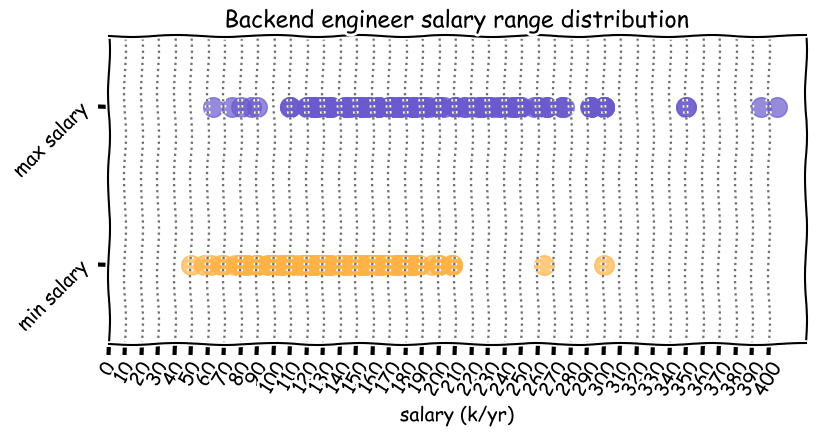

In [19]:
y_min = [1] * len(min_amount_yearly)
y_max = [2] * len(max_amount_yearly)

plt.xkcd()

plt.figure(figsize=(9, 4))
plt.scatter([x/1000 for x in min_amount_yearly], y_min, s=200, color='#FFB347', label='List1', marker='o', alpha=0.7)
plt.scatter([x/1000 for x in max_amount_yearly], y_max, s=200, color='#6A5ACD', label='List2', marker='o', alpha=0.7)

# Customize axes
plt.xticks(range(0, int(max(max_amount_yearly)/1000), 10), rotation=60)
plt.yticks([1,2], ['min salary', 'max salary'], rotation=45)
plt.xlabel('salary (k/yr)')
y_min = 0.5
y_max = 2.45
plt.ylim(y_min, y_max)
plt.title('Backend engineer salary range distribution')
plt.grid(axis='x', linestyle=':', linewidth=1.65, color='#333333', alpha=0.7)

plt.show()

It feels like the lower end of most salary ranges between \\$50k - \\$210k and the higher end of most salary ranges from \\$65k to \\$300k. By my own job browsing experience, this is pretty accurate. Compared to most tech jobs, this actually seems a bit low (quite low). If you search for data scientist or ML Eng jobs, the higher end could easily go up to around 600k to 800k. The following analysis will show,  however, **why in my opinion, backend engineering is a great first job for job seekers in this market and will likely open up further opportunities.**

**P.S.** If you're wondering why the graph is all doodles it's because of this magical command `plt.xkcd()`. You don't have to download extra packages because it's included in `matplotlib` but you do have to suppress the font manager warnings using `logging.getLogger("matplotlib.font_manager").disabled = True`.

In [20]:
import plotly.graph_objects as go

In [21]:
min_amount_yearly = jobs[jobs.interval == 'yearly'].min_amount.dropna()
max_amount_yearly = jobs[jobs.interval == 'yearly'].max_amount.dropna()
min_amount_hourly = jobs[jobs.interval == 'hourly'].min_amount.dropna()
max_amount_hourly = jobs[jobs.interval == 'hourly'].max_amount.dropna()
min_amount_hourly = min_amount_hourly * 40 * 4 * 12
max_amount_hourly = max_amount_hourly * 40 * 4 * 12
min_amount_yearly = pd.concat([min_amount_yearly, min_amount_hourly], ignore_index=True)
max_amount_yearly = pd.concat([max_amount_yearly, max_amount_hourly], ignore_index=True)

indices = jobs.min_amount.dropna().index.tolist()
areas_with_valid_rates = jobs.loc[indices].area.tolist()

data = {"area": areas_with_valid_rates,
       "min_amount": min_amount_yearly.tolist(),
       "max_amount": max_amount_yearly.tolist()}

df_salary_by_area = pd.DataFrame(data)
df_area_min_salary_median = (
    df_salary_by_area.groupby("area")
    .agg(
        min_amount_median=("min_amount", "median"),
        count=("min_amount", "count")   # count rows per area
    )
    .reset_index()
)

# ---- Median max salary + count ----
df_area_max_salary_median = (
    df_salary_by_area.groupby("area")
    .agg(
        max_amount_median=("max_amount", "median"),
        count=("max_amount", "count")   # same count (based on max_amount)
    )
    .reset_index()
)

In [22]:
area_counts = pd.read_csv(root_dir+"area2latlon.csv")

In [23]:
df_area_min_salary_median = df_area_min_salary_median.merge(
    area_counts[['area', 'lat', 'lon']],
    on='area',
    how='left'
)

# Get sets of areas
all_areas = set(jobs["area"])
median_areas = set(df_area_min_salary_median["area"])

# Areas present in jobs but missing in median
missing_areas = list(all_areas - median_areas)

# Subset lat/lon for missing areas
missing_coords = area_counts[area_counts["area"].isin(missing_areas)][['area', 'lat', 'lon']]

In [24]:
# Base bubble map for median salaries
fig = px.scatter_geo(
    df_area_min_salary_median,
    lat="lat",
    lon="lon",
    size="min_amount_median",
    color="min_amount_median",
    hover_name="area",
    hover_data={
        "min_amount_median": True,
        "count": True,       # <-- add your jobs column here
        "lat": False,        # hide lat/lon if you want
        "lon": False
    },
    size_max=50,
    opacity=0.7,
    color_continuous_scale="Viridis",
    projection="albers usa"
)

# Add missing areas as 'X' markers with white background for text
fig.add_trace(
    go.Scattergeo(
        lat=missing_coords['lat'],
        lon=missing_coords['lon'],
        mode='markers+text',
        marker=dict(symbol='x', size=12, color='red'),
        text=missing_coords['area'],
        textposition="top center",
        textfont=dict(
            size=12,
            color='#333333',
        ),
        name='Missing Areas',
    )
)

# Mid-tone map style with black state lines
fig.update_layout(
    title="Median Min Yearly Amount by City (with Missing Areas Marked)",
    title_font_size=20,
    title_font_color="#555555",
    geo=dict(
        scope="usa",
        showland=True,
        landcolor="#e0e0e0",
        lakecolor="#d0e8ff",
        showlakes=True,
        showcountries=True,
        countrycolor="gray",
        showcoastlines=False,
        bgcolor="#f5f5f5",
        showsubunits=True,
        subunitcolor="black",
    ),
    paper_bgcolor="#f5f5f5",
    font=dict(color="black"),
    margin={"r":0,"t":50,"l":0,"b":0},
    height=400,
    width=700,
)

fig.update_layout(
    legend=dict(
        x=0.02,           # move legend left
        y=0.98,
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="black",
        borderwidth=1
    )
)

fig.write_html("min_salary_map.html", full_html=False, include_plotlyjs='cdn')

fig.show()

In [25]:
df_area_max_salary_median = df_area_max_salary_median.merge(
    area_counts[['area', 'lat', 'lon']],
    on='area',
    how='left'
)

In [26]:
# Base bubble map for median salaries
fig = px.scatter_geo(
    df_area_max_salary_median,
    lat="lat",
    lon="lon",
    size="max_amount_median",
    color="max_amount_median",
    hover_name="area",
    hover_data={
        "max_amount_median": True,
        "count": True,       # <-- add your jobs column here
        "lat": False,        # hide lat/lon if you want
        "lon": False
    },
    size_max=50,
    opacity=0.7,
    color_continuous_scale="Viridis",
    projection="albers usa"
)

# Add missing areas as 'X' markers with white background for text
fig.add_trace(
    go.Scattergeo(
        lat=missing_coords['lat'],
        lon=missing_coords['lon'],
        mode='markers+text',
        marker=dict(symbol='x', size=12, color='red'),
        text=missing_coords['area'],
        textposition="top center",
        textfont=dict(
            size=12,
            color='#333333',
        ),
        name='Missing Areas',
    )
)

# Mid-tone map style with black state lines
fig.update_layout(
    title="Median Max Yearly Amount by City (with Missing Areas Marked)",
    title_font_size=20,
    title_font_color="#555555",
    geo=dict(
        scope="usa",
        showland=True,
        landcolor="#e0e0e0",
        lakecolor="#d0e8ff",
        showlakes=True,
        showcountries=True,
        countrycolor="gray",
        showcoastlines=False,
        bgcolor="#f5f5f5",
        showsubunits=True,
        subunitcolor="black",
    ),
    paper_bgcolor="#f5f5f5",
    font=dict(color="black"),
    margin={"r":0,"t":50,"l":0,"b":0},
    height=400,
    width=700,
)

fig.update_layout(
    legend=dict(
        x=0.02,           # move legend left
        y=0.98,
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="black",
        borderwidth=1
    )
)

fig.write_html("max_salary_map.html", full_html=False, include_plotlyjs='cdn')

fig.show()

The first thing to notice is a few cities you wouldn't normally expect to have high median salaries have higher median salaries than big tech cities like East coast cities and even San Francisco and San Jose. If you hover on the bubbles, the labels tell you how many job in that city had salary stated in the listing. It's clear from the job count labels that most of these cities only have 1 to 3 jobs that have salary labels, which means those are the only salaries to take median values from. What it means is that at least the median salary of these cities could not be fully trusted. Another possible interpretation could be that only companies who can offer good salary listed the number, which sound much more possible but is hard to verify for sure.

The couple other things to notice is that San Diego, CA has a bit more jobs (5) that have salary listing and higher salary median, \\$172k/yr - \\$258k/yr. Next, the following cities have a couple salary listings that showed that they actually don't pay that well (diabolically).

- Salt Lake City, UT (\\$101k/yr - \\$108.5k/yr)
- Milwaukee, WI (\\$77k/yr - \\$86k/yr)
- Detroit, MI (\\$80k/yr - \\$110k/yr)
- Indianapolis, IN (\\$70k/yr - \\$75k/yr)
- Birmingham, AL (\\$90k/yr - \\$110k/yr)

The fact that these cities only have a couple salary listings are already suspicious. Moreover, the median salaries in most cities on the graph is \\$130k/yr - \\$195k/yr if you hover over the darker green bubbles. So having only a couple listings that ranges from around \\$80k/yr to barely reaching \\$110k/yr demonstrates that these cities might not have the most well-paid jobs. 

Lastly, the cities that don't have jobs with salary listed are a mix of a couple big cities or cities that I know have good tech jobs like Hartford, CT, and major cities from red states. I'd not draw any definite conclusions from it.

## 🏅 Job Level

Data scientist jobs collected from a few sampled big tech cities are used here in comparison to the backend engineering job dataset.

In [27]:
jobs_ds = pd.read_csv(root_dir+"jobs_ds.csv")
print(f"The data scientist dataset has {jobs_ds.shape[0]} jobs. ")

The data scientist dataset has 834 jobs. 


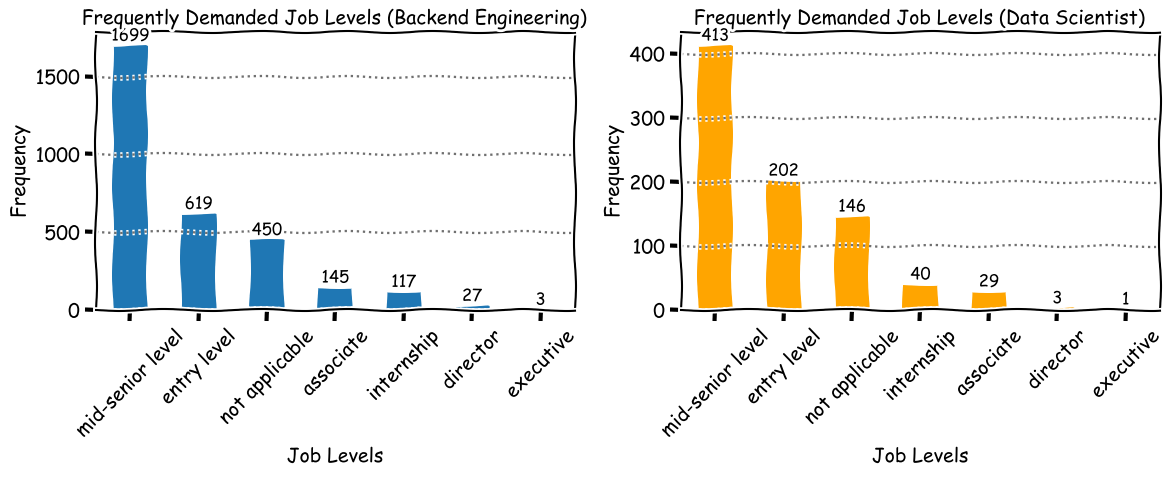

In [28]:
# Prepare data
levels_backend = jobs.job_level
levels_freq_backend = levels_backend.value_counts()

levels_ds = jobs_ds.job_level
levels_freq_ds = levels_ds.value_counts()

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Backend Engineering Plot ---
levels_freq_backend.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel("Job Levels")
axes[0].set_ylabel("Frequency")
axes[0].set_xticklabels(levels_freq_backend.index, rotation=45)
axes[0].grid(axis='y', linestyle=':', linewidth=1.65, color='#333333', alpha=0.7)

# Add numerical labels
for i, value in enumerate(levels_freq_backend):
    axes[0].text(i, value + 0.05, str(value), ha='center', va='bottom', fontsize=12)

axes[0].set_title("Frequently Demanded Job Levels (Backend Engineering)", fontsize=14)

# --- Data Scientist Plot ---
levels_freq_ds.plot(kind='bar', ax=axes[1], color='orange')  # optional color change
axes[1].set_xlabel("Job Levels")
axes[1].set_ylabel("Frequency")
axes[1].set_xticklabels(levels_freq_ds.index, rotation=45)
axes[1].grid(axis='y', linestyle=':', linewidth=1.65, color='#333333', alpha=0.7)

# Add numerical labels
for i, value in enumerate(levels_freq_ds):
    axes[1].text(i, value + 0.05, str(value), ha='center', va='bottom', fontsize=12)

axes[1].set_title("Frequently Demanded Job Levels (Data Scientist)", fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig("job_levels.png", dpi=300, bbox_inches="tight")

In agreement with the trends in the tech industry, there are more mid to senior level jobs than entry-level jobs. In comparison to the most popular job title "Data Scientist", of which in this sampled dataset from major tech cities half of which the job is entry-level, about 36.4% of backend engineering jobs across the US is entry-level jobs, which is pretty good. Moreover, the definition of mid-senior level jobs could be different for backend engineers compared to data scientists. Because data scientists require various understanding of machine learning or deep learning as well as requirements of a masters or even PhD degree, it's much more difficult to get to mid-senior level. In comparison, it's much easier to get to mid-senior level as a backend engineer. 

In [29]:
mid_senior_jobs = jobs[jobs["job_level"] == "mid-senior level"]
entry_jobs = jobs[jobs["job_level"] == "entry level"]

mid_senior_counts = mid_senior_jobs.groupby("area").size().reset_index(name="job_count")
entry_counts = entry_jobs.groupby("area").size().reset_index(name="job_count")

# Merge lat/lon
mid_senior_counts = mid_senior_counts.merge(area_counts[['area','lat','lon']], on='area', how='left')
entry_counts = entry_counts.merge(area_counts[['area','lat','lon']], on='area', how='left')

In [30]:
# Entry Level Map
fig2 = px.scatter_geo(
    entry_counts,
    lat="lat",
    lon="lon",
    size="job_count",
    color="job_count",
    hover_name="area",
    size_max=50,
    opacity=0.7,
    color_continuous_scale="Viridis",
    projection="albers usa",
    title="Entry Level Job Count by City"
)

fig2.update_layout(
    geo=dict(
        scope="usa",
        showland=True,
        landcolor="#e0e0e0",
        lakecolor="#d0e8ff",
        showlakes=True,
        showcountries=True,
        countrycolor="gray",
        showcoastlines=False,
        bgcolor="#f5f5f5",
        showsubunits=True,
        subunitcolor="black",
    ),
    paper_bgcolor="#f5f5f5",
    height=400,
    width=700,
)

fig2.show()
fig2.write_html("entry_job_map.html", full_html=False, include_plotlyjs='cdn')

# Mid-Senior Level Map
fig1 = px.scatter_geo(
    mid_senior_counts,
    lat="lat",
    lon="lon",
    size="job_count",
    color="job_count",
    hover_name="area",
    size_max=50,
    opacity=0.7,
    color_continuous_scale="Viridis",
    projection="albers usa",
    title="Mid-Senior Level Job Count by City"
)

fig1.update_layout(
    geo=dict(
        scope="usa",
        showland=True,
        landcolor="#e0e0e0",
        lakecolor="#d0e8ff",
        showlakes=True,
        showcountries=True,
        countrycolor="gray",
        showcoastlines=False,
        bgcolor="#f5f5f5",
        showsubunits=True,
        subunitcolor="black",
    ),
    paper_bgcolor="#f5f5f5",
    height=400,
    width=700,
)

fig1.show()
fig1.write_html("mid_senior_job_map.html", full_html=False, include_plotlyjs='cdn')

It seems like the following cities have more entry-level jobs, ranked from the most jobs to fewer jobs:

- Seattle, CA (38)
- Sacramento, CA (33)
- Denver, CO (32)
- San Jose, CA (30)
- San Francisco, CA (28)
- Baltimore, MD (28)
- Boston, MA (25)
- Washington D.C., D.C. (25)

And the following cities have more mid-senior level jobs, a bit more than 90 jobs: New York, NY / Baltimore, MD / Washington D.C., D.C. / Boston, MA / Denver, CO. Atlanta and Chicago each have around 70 jobs, while cities in the West Coast actually have a bit less (around 60) of them. 

## 🏢 Companies

In [31]:
from wordcloud import WordCloud

In [32]:
company_counts = jobs['company'].value_counts()

# View top 10 most mentioned companies
top_companies = company_counts.head(25)
print(top_companies)

company
Epic                         136
Jobs via Dice                 65
Google                        47
PwC                           35
ExecutivePlacements.com       34
KPMG US                       34
Intuit                        25
GEICO                         25
EY                            23
Qualcomm                      22
Pearson                       22
Booz Allen Hamilton           21
Meta                          21
Tata Consultancy Services     19
Uline                         18
Mindrift                      18
Adobe                         18
Motion Recruitment            17
Affirm                        17
Capital One                   16
Lockheed Martin               16
Deloitte                      16
Scribd, Inc.                  15
Boeing                        15
Raytheon                      15
Name: count, dtype: int64


In [33]:
google = company_counts["Google"]
meta = company_counts["Meta"]
amazon = company_counts["Amazon"]
netflix = company_counts["Netflix"]
apple = 0
if "Apple" in company_counts.index: 
    apple = company_counts["Apple"]
print(f"# of FANNG jobs \nGoogle: {google}\nMeta: {meta} \nAmazon: {amazon} \nNetflix: {netflix} \nApple: {apple}")

# of FANNG jobs 
Google: 47
Meta: 21 
Amazon: 1 
Netflix: 14 
Apple: 0


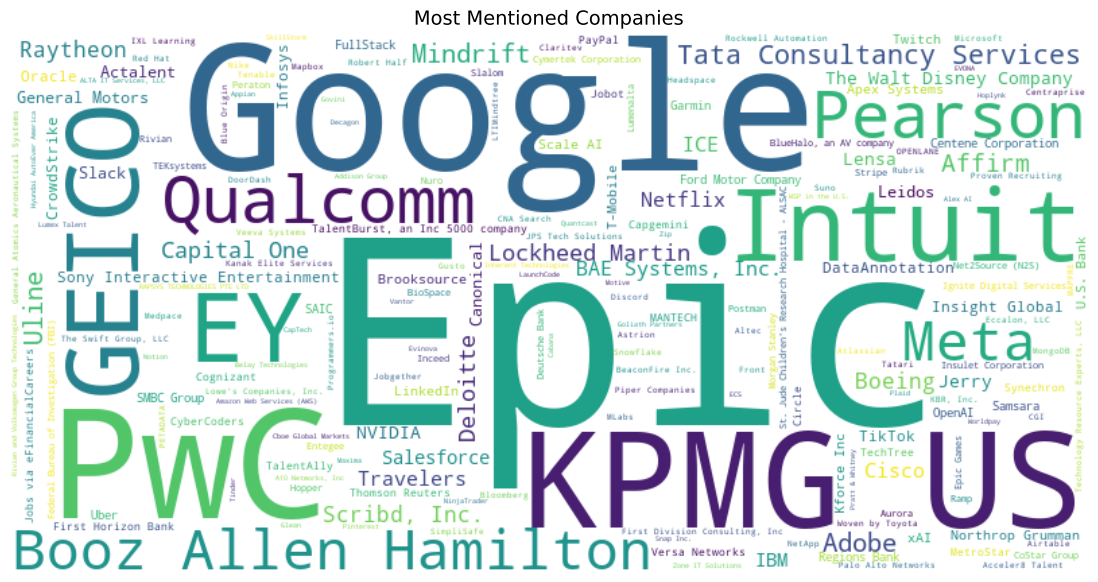

In [34]:
# List of companies to remove
remove_companies = ["Jobs via Dice", "ExecutivePlacements.com", "Motion Recruitment"]

# Filter out these companies from the frequency dictionary
company_freq_filtered = {company: count for company, count in company_counts.items() if company not in remove_companies}

# Generate the word cloud from the filtered dictionary
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(company_freq_filtered)

# Plot
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Mentioned Companies", fontsize=24, font="DejaVu Sans")
plt.show()

svg = wordcloud.to_svg()

with open("company_wordcloud.svg", "w", encoding="utf-8") as f:
    f.write(svg)

By getting the most mentioned companies in this dataset, we can see that Epic the electronic health record (EHR) system listed the most backend engineering jobs (136 jobs). While some suspicious job websites are up on the list, like Jobs via Dice, ExecutivePlacement.com and Motion Recruitment, most of the companies are well-known like Google, PwC, etc. Some of the other well-known company on the list are: KPMG US, EY, Intuit, PwC, Qualcomm, Tata Consultancy Services, Booz Allen Hamilton, Affirm, Pearson, GEICO, and companies with less backend engineering jobs like Adobe, IBM, Lockheed Martin, Deloitte, NVIDIA and Boeing. 

A quick check people like to do is to look for FAANG company jobs. FAANG are five big tech companies recognized in the industry, standing for Facebook (now Meta), Amazon, Apple, Netflix, and Alphabet (Google) respectively. Here we have Google: 47 jobs, Meta: 21 jobs, Amazon: 1 job and Netflix: 14 jobs. Apple has no job listed, just because they don't post ANY job on ANY job boards and only on their own career website, so it's normal that our dataset doesn't contain any job from Apple. Our job source is LinkedIn.

## 🏭 Industry

In [35]:
industry = jobs.company_industry

# List of companies to remove
remove_companies = ["Jobs via Dice", "ExecutivePlacements.com", "Motion Recruitment"]

# Filter the jobs dataframe to exclude these companies
jobs_filtered = jobs[~jobs['company'].isin(remove_companies)]

industry_counts = jobs_filtered['company_industry'].value_counts()

# Get top 10 most frequent industries
top_industries = industry_counts.head(7)
print(top_industries)

company_industry
Software Development                                                                      486
IT Services and IT Consulting                                                             353
Financial Services                                                                        217
Technology, Information and Internet                                                      151
Defense and Space Manufacturing                                                           117
Insurance                                                                                  79
Software Development, Hospitals and Health Care, and Information Technology & Services     68
Name: count, dtype: int64


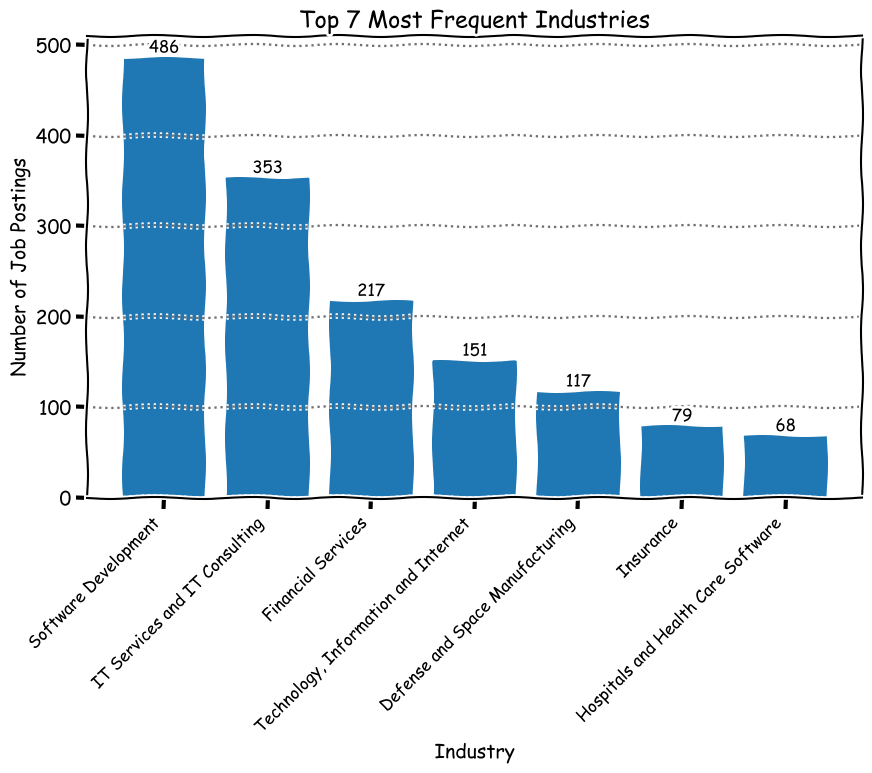

In [36]:
import matplotlib.pyplot as plt

# Convert top_industries to a dataframe for easier manipulation
top_industries_df = top_industries.reset_index()
top_industries_df.columns = ['industry', 'count']

# Rename the 7th industry (index 6) to "Hospitals and Health Care Software"
top_industries_df.loc[6, 'industry'] = "Hospitals and Health Care Software"

# Plot as bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(top_industries_df['industry'], top_industries_df['count'])

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x-position
        height + 0.5,                     # y-position slightly above bar
        str(int(height)),                  # label text
        ha='center', va='bottom', fontsize=12
    )

plt.xticks(fontsize=12)
plt.xlabel("Industry")
plt.ylabel("Number of Job Postings")
plt.title("Top 7 Most Frequent Industries")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle=':', linewidth=1.65, color='#333333', alpha=0.7)

plt.savefig("freq_industry.png", dpi=300, bbox_inches="tight")
plt.show()

Most jobs are from the software development, consulting or financial services industry. Other more specific industries are Defense and Space Manufacturing, Insurance and Healthcare Software. Some examples of software development industry companies could be Slack, Pearson and Scribd, Inc. Consulting companies are straightforward, like EY and PwC. Financial services companies include Affirm, Intuit and Capital One. 

## 🌐 Is Remote

In [37]:
is_remote = jobs_filtered.is_remote
remote_counts = jobs['is_remote'].value_counts()
print(remote_counts)

is_remote
False    2322
True      738
Name: count, dtype: int64


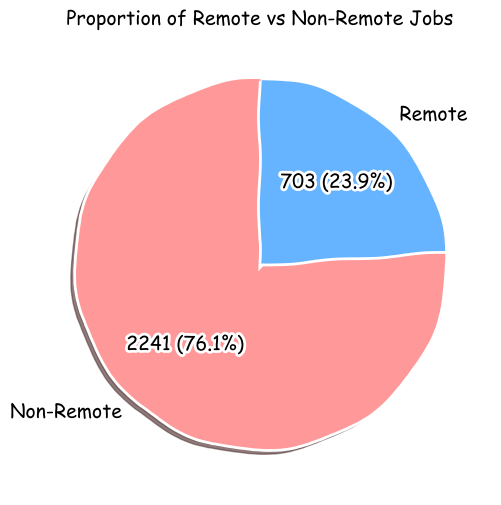

In [38]:
# Count remote vs non-remote jobs
remote_counts = jobs_filtered['is_remote'].value_counts()
labels = ['Non-Remote', 'Remote']

# Custom function to show both count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct*total/100.0))
        return f"{count} ({pct:.1f}%)"
    return my_autopct

plt.figure(figsize=(6,6))
plt.pie(
    remote_counts,
    labels=labels,
    autopct=make_autopct(remote_counts),
    colors=['#FF9999','#66B3FF'],
    startangle=90,
    shadow=True
)
plt.title("Proportion of Remote vs Non-Remote Jobs", fontsize=14)

plt.savefig("remote_jobs.png", dpi=300, bbox_inches="tight")
plt.show()

In [39]:
# Filter remote jobs
remote_jobs = jobs_filtered[jobs_filtered['is_remote'] == True]

# Group by area/city and count jobs
remote_counts = remote_jobs.groupby("area").size().reset_index(name="job_count")

# Merge lat/lon for plotting (assuming area_counts dataframe exists)
remote_counts = remote_counts.merge(area_counts[['area','lat','lon']], on='area', how='left')

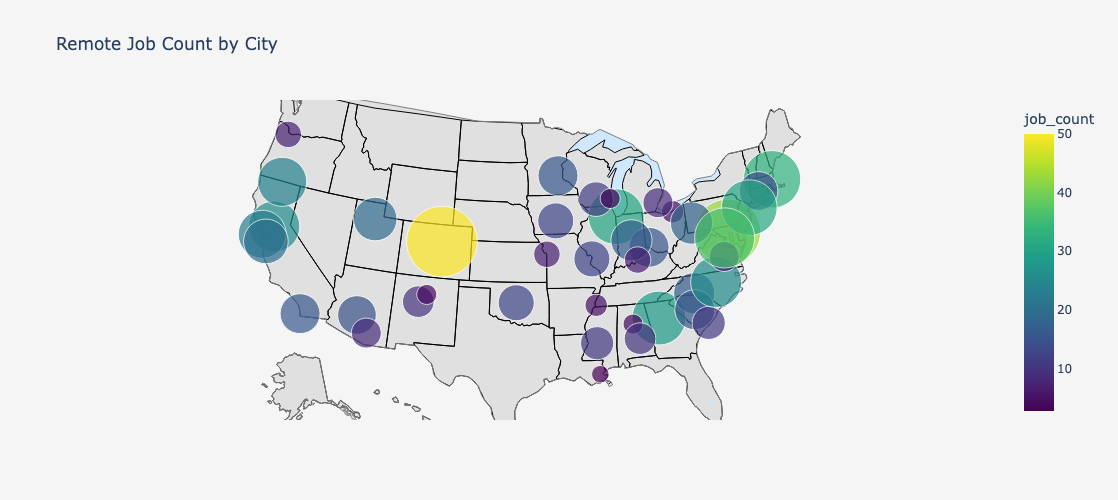

In [40]:
fig = px.scatter_geo(
    remote_counts,
    lat="lat",
    lon="lon",
    size="job_count",
    color="job_count",
    hover_name="area",
    size_max=50,
    opacity=0.7,
    color_continuous_scale="Viridis",
    projection="albers usa",
    title="Remote Job Count by City"
)

# Map layout styling
fig.update_layout(
    geo=dict(
        scope="usa",
        showland=True,
        landcolor="#e0e0e0",
        lakecolor="#d0e8ff",
        showlakes=True,
        showcountries=True,
        countrycolor="gray",
        showcoastlines=False,
        bgcolor="#f5f5f5",
        showsubunits=True,
        subunitcolor="black",
    ),
    paper_bgcolor="#f5f5f5",
    height=500,
    width=700,
)

fig.write_html("remote_job_map.html", full_html=False, include_plotlyjs='cdn')
fig.show()

After filtering out the jobs from sketchy recruiting website like Dice, we see that about a quarter of the jobs are Remote. Separating remote jobs by city, the map shows that Denver (50), Baltimore (43), Washington DC (36), Boston, New York and Chicago. All of them have more than 30 remote jobs. Atlanta and Raleigh don't have as much but still a decent amount (29 jobs and 26 jobs, respectively). 

Additionally, it's interesting from all of the above analysis, traditionally well-regarded big tech cities like San Francisco and Seattle are seldom mentioned. Aside from the fact that those California cities have well-paid jobs, it seems like **New York, Denver, Baltimore, Washington DC, Boston, Chicago, Atlanta and Raleigh** have comparably well-paid jobs that are entry, mid-senior level and remote. One more specific thing you can look for by yourself is which city have which industry. This is too detailed for this review, but the dataset of all jobs, as well as by city and the sampled data scientist dataset will be uploaded to [Kaggle](www.kaggle.com) and available for download in the beginning and end of the notebook. 

## 🇹 Description (years of experience, skills, perks, visa requirements etc.)

This section is divided into 4 components. First, the about section of a job description is extracted; then requirements, responsibilities and benefits are extracted if available. For 

In [4]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import wordfreq

In [5]:
print(jobs.description[182])

**About Us**
 Collaborative autonomy is how self\\-tasking teams of machines will solve hard human problems, and HavocAI is an unquestioned leader in collaborative autonomy. We set the standard for autonomous surface vessels for a wide range of defense and commercial maritime missions. Success requires us to grow quickly, and we’re looking for teammates who are passionate about solving hard problems, about pushing the envelope, and about preventing conflict and saving lives. Ambition is welcome to apply within.
   

  

**About The Role**
 We are seeking a Senior Software Engineer to lead our international software development efforts and drive the architectural separation of our codebase for export compliance (EAR). This role blends deep software engineering expertise with systems integration, technical leadership, and cross\\-cultural collaboration. You will own a major company initiative: enabling HavocAI to build, maintain, and deploy autonomy software across multiple countries whi

## Utility function: extract about section

In [6]:
description = jobs.description[182]
description = description.replace("\\", "")
print(description)

**About Us**
 Collaborative autonomy is how self-tasking teams of machines will solve hard human problems, and HavocAI is an unquestioned leader in collaborative autonomy. We set the standard for autonomous surface vessels for a wide range of defense and commercial maritime missions. Success requires us to grow quickly, and we’re looking for teammates who are passionate about solving hard problems, about pushing the envelope, and about preventing conflict and saving lives. Ambition is welcome to apply within.
   

  

**About The Role**
 We are seeking a Senior Software Engineer to lead our international software development efforts and drive the architectural separation of our codebase for export compliance (EAR). This role blends deep software engineering expertise with systems integration, technical leadership, and cross-cultural collaboration. You will own a major company initiative: enabling HavocAI to build, maintain, and deploy autonomy software across multiple countries while p

In [7]:
HEADER_PATTERN = re.compile(r'\*\*(.*?)\*\*\n', re.IGNORECASE)

def extract_about_section(text: str) -> str | None:
    # 1. Find all headers with positions
    headers = list(HEADER_PATTERN.finditer(text))
    if not headers:
        return None

    # 2. Find the header containing "about"
    about_idx = None
    for i, match in enumerate(headers):
        if "about" in match.group(1).lower():
            about_idx = i
            break

    if about_idx is None:
        return None

    start = headers[about_idx].end()

    # 3. Determine end position
    if about_idx + 1 < len(headers):
        end = headers[about_idx + 1].start()
        return text[start:end].strip()
    else:
        # 4. Last header → return rest of text
        return text[start:].strip()

In [8]:
about = extract_about_section(description)
print(about)

Collaborative autonomy is how self-tasking teams of machines will solve hard human problems, and HavocAI is an unquestioned leader in collaborative autonomy. We set the standard for autonomous surface vessels for a wide range of defense and commercial maritime missions. Success requires us to grow quickly, and we’re looking for teammates who are passionate about solving hard problems, about pushing the envelope, and about preventing conflict and saving lives. Ambition is welcome to apply within.


## Utility functions: extract other sections

In [9]:
HEADER_PATTERN = re.compile(r'\*\*(.*?)\*\*\n')

def match_sections_helper(text: str) -> list[str]:
    headers = list(HEADER_PATTERN.finditer(text))
    results = []

    for i, match in enumerate(headers):
        header_text = match.group(1).lower()

        # Check if header contains "what"
        if "what" not in header_text:
            continue

        start = match.end()

        # Determine section end
        if i + 1 < len(headers):
            end = headers[i + 1].start()
            section = text[start:end]
        else:
            section = text[start:]

        results.append(section.strip())

    return results

def match_sections(sections):
    responsibility = []
    benefits = []
    requirements = []

    resp_pattern = re.compile(r"\bresponsibilit(?:y|ies)\b", re.IGNORECASE)
    benefit_pattern = re.compile(r"\b(?:offer|benefit|benefits)\b", re.IGNORECASE)

    for text in sections:
        matched = False

        if resp_pattern.search(text):
            responsibility.append(text)
            matched = True

        if benefit_pattern.search(text):
            benefits.append(text)
            matched = True

        if not matched:
            requirements.append(text)

    return responsibility, requirements, benefits

def extract_job_info(text):
    '''Based on the fact that the desired sections in a job description
    usually starts with a section title surrounded by two stars (**), a 
    list of bullet points starting with (*), ends with two new lines (\n\n),
    extract such sections. 
    
    The first section usually describes responsibilities, followed by a
    couple to a few blocks that describes the skills requirements and an
    optional block describing the benefits.'''
    text = text.replace("\\", "")
    pattern = re.compile(
        r"""
        (                               # capture full block
            ^\* \* .+                   # first line: "* * ..."
            (?:\n\* .+)+                # 1+ following lines: "* ..."
        )
        (?=\n\n|$)                      # stop at blank line or end
        """,
        re.MULTILINE | re.VERBOSE
    )

    sections = [m.strip() for m in pattern.findall(text)]

    responsibility, requirements, benefits = match_sections(sections)

    if len(responsibility) == 0 or len(requirements) == 0:
        sections = match_sections_helper(text)
        if len(sections) == 1: 
            responsibility = [sections[0]]
            requirements = []
        elif len(sections) == 2:
            responsibility = [sections[0]]
            requirements = [sections[1]]
        else:
            responsibility = []
            requirements = []
        benefits = []

    return responsibility, requirements, benefits

In [10]:
def print_texts(texts):
    for text in texts:
        print(text)

In [11]:
responsibility, requirements, benefits = extract_job_info(description)

In [12]:
benefits

['**Benefits**\n* 100% Employer paid Health, Dental and Vision Insurance for you and your families\n* Life Insurance\n* Ability to participate in the companies 401k program\n* Unlimited PTO policy with an enforced 2 week minimum\n* Equity Package\n* Work / Home Office Stipend\n* Global Entry\n* 16 Week Paid Parental Leave\n* Monthly Health and Wellness Stipend']

In [13]:
print_texts(benefits)

**Benefits**
* 100% Employer paid Health, Dental and Vision Insurance for you and your families
* Life Insurance
* Ability to participate in the companies 401k program
* Unlimited PTO policy with an enforced 2 week minimum
* Equity Package
* Work / Home Office Stipend
* Global Entry
* 16 Week Paid Parental Leave
* Monthly Health and Wellness Stipend


## Utility functions: extract skills

In [14]:
# Extract skill keywords
def preprocess_text(text: str) -> str:
    # 1. Remove anything surrounded by **
    text = re.sub(r"\*\*.*?\*\*", "", text, flags=re.DOTALL)

    processed_sentences = []

    # 2 & 3. Split by "* " (bullet points)
    sentences = re.split(r"\*\s+", text.strip())

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue

        # 4. Skip first word of each sentence
        sentence_wo_first = re.sub(r'^\s*\S+\s*', '', sentence)

        if sentence_wo_first:
            # 5. Remove period only if it is at the end of the sentence
            sentence_wo_first = re.sub(r'\.$', '', sentence_wo_first)
            processed_sentences.append(sentence_wo_first)

    return " ".join(processed_sentences)


def extract_skills(text, zipf_threshold=2):
    text = preprocess_text(text)
    terms = set()

    token_pattern = (
        r"\b[A-Z][A-Za-z0-9+.#-]+(?![A-Za-z0-9+.#-])"
        r"|\b[A-Z]{2,}\b"
    )
    
    # Tokenize words with positions
    tokens = list(
        re.finditer(token_pattern, text)
    )

    i = 0
    while i < len(tokens):
        current = tokens[i].group()

        # Check if next token exists and is consecutive (separated by space)
        if i + 1 < len(tokens):
            next_token = tokens[i + 1]
            between = text[tokens[i].end():next_token.start()]

            if between.isspace():
                combined = f"{current}_{next_token.group()}"
                terms.add(combined)
                i += 2
                continue

        terms.add(current)
        i += 1

    return terms

In [15]:
print(requirements[0])

**Qualifications**
* Bachelor’s or Master’s degree in Computer Science, Robotics, Electrical Engineering, or a related field.
* 5+ years of software engineering experience with proficiency in C++.
* Familiarity with export compliance concepts (EAR/ITAR) or experience working in regulated or classified environments.
* Experience architecting or maintaining large, modular codebases with strict interface boundaries.
* Experience with ROS/ROS2, autonomy frameworks, or real-world robotic systems.
* Strong background with Linux, modern software tooling, and CI/CD pipelines.
* Excellent communication skills with the ability to coordinate across distributed, multicultural teams.
* Must be a U.S. Citizen and eligible to obtain a Secret Clearance.


In [16]:
extract_skills(requirements[-1])

{'All_Tasks', 'At_HavocAI', 'Empowering', 'Every', 'Leadership', 'We'}

In [17]:
extract_skills(responsibility[-1])

{'CD', 'CI', 'EAR-controlled', 'HavocAI', 'U.S.'}

## Utility functions: extract conceptual requirements

In [18]:
PREPOSITIONS = {
    "in", "on", "at", "for", "with", "to", "from", "by", "of", "about", "as"
}

CONJUNCTIONS = {
    "and", "or", "but", "nor", "yet", "so"
}

level_experience = ["experience", "ability"]
level_background = ["understanding", "grasp", "background", "familarity"]
experience_with = []
background_of = []

In [19]:
def split_to_sentences(text: str) -> list[str]:
    # 1. Remove anything surrounded by **
    text = re.sub(r"\*\*.*?\*\*", "", text, flags=re.DOTALL)

    # 2 & 3. Split by "* " (bullet points)
    sentences = re.split(r"\*\s+", text.strip())[1:]

    processed = []
    for sentence in sentences:
        # Remove newlines
        sentence = sentence.replace("\n", "").strip()

        if sentence:
            # Decapitalize first letter only
            sentence = sentence[0].lower() + sentence[1:]
            processed.append(sentence)

    return processed

In [20]:
def extract_phrases(requirement, keywords):
    sentences = split_to_sentences(requirement)
    results = []

    keyword_pattern = re.compile(
        r"\b(" + "|".join(map(re.escape, keywords)) + r")\b",
        re.IGNORECASE
    )

    prep_pattern = re.compile(
        r"\b(" + "|".join(PREPOSITIONS) + r")\b",
        re.IGNORECASE
    )

    conj_pattern = re.compile(
        r"^\s*(?:and|or|but|nor|yet|so)\b\s+",
        re.IGNORECASE
    )

    for sentence in sentences:
        kw_match = keyword_pattern.search(sentence)
        if not kw_match:
            continue

        kw_end = kw_match.end()

        preps = [
            p for p in prep_pattern.finditer(sentence)
            if p.start() > kw_end
        ]

        # extracted is now a LIST
        extracted = []

        if len(preps) >= 2:
            extracted.append(sentence[preps[0].end():preps[1].start()])
            extracted.append(sentence[preps[1].end():])

        elif len(preps) == 1:
            extracted.append(sentence[kw_end:preps[0].start()])
            extracted.append(sentence[preps[0].end():])

        else:
            extracted.append(sentence[kw_end:])

        # Clean conjunctions
        cleaned = [
            conj_pattern.sub("", term).strip()
            for part in extracted
            for term in part.split(",")
            if term.strip()
        ]

        if cleaned:
            results.extend(cleaned)

    return results

In [21]:
n = 0
experience_with = extract_phrases(requirements[n], level_experience)
print(requirements[n], "\n", experience_with)

**Qualifications**
* Bachelor’s or Master’s degree in Computer Science, Robotics, Electrical Engineering, or a related field.
* 5+ years of software engineering experience with proficiency in C++.
* Familiarity with export compliance concepts (EAR/ITAR) or experience working in regulated or classified environments.
* Experience architecting or maintaining large, modular codebases with strict interface boundaries.
* Experience with ROS/ROS2, autonomy frameworks, or real-world robotic systems.
* Strong background with Linux, modern software tooling, and CI/CD pipelines.
* Excellent communication skills with the ability to coordinate across distributed, multicultural teams.
* Must be a U.S. Citizen and eligible to obtain a Secret Clearance. 
 ['proficiency', 'C++.', 'working', 'regulated or classified environments.', 'architecting or maintaining large', 'modular codebases', 'strict interface boundaries.', 'ROS/ROS2', 'autonomy frameworks', 'real-world robotic systems.', 'coordinate across

## Utility function: get benefits

In [22]:
def get_benefits(texts: list[str]) -> list[str]:
    results = []
    for text in texts:
        bullet_points = text.split("\n* ")[1:]
        results.extend(bullet_points)
    return results

In [23]:
benefits

['**Benefits**\n* 100% Employer paid Health, Dental and Vision Insurance for you and your families\n* Life Insurance\n* Ability to participate in the companies 401k program\n* Unlimited PTO policy with an enforced 2 week minimum\n* Equity Package\n* Work / Home Office Stipend\n* Global Entry\n* 16 Week Paid Parental Leave\n* Monthly Health and Wellness Stipend']

In [24]:
benefits = get_benefits(benefits)
benefits

['100% Employer paid Health, Dental and Vision Insurance for you and your families',
 'Life Insurance',
 'Ability to participate in the companies 401k program',
 'Unlimited PTO policy with an enforced 2 week minimum',
 'Equity Package',
 'Work / Home Office Stipend',
 'Global Entry',
 '16 Week Paid Parental Leave',
 'Monthly Health and Wellness Stipend']

## Putting it all together: gather data

In [25]:
import json

In [26]:
def extract_sections_for_description(description):
    about = extract_about_section(description)
    responsibility, requirements, benefits = extract_job_info(description)
    
    skills = []
    key_phrases_exp = []
    key_phrases_bg = []
    
    for r in responsibility:
        skills_r = list(extract_skills(r))
        skills.extend(skills_r)
        key_phrases_r_exp = extract_phrases(r, level_experience)
        if key_phrases_r_exp: key_phrases_exp.extend(key_phrases_r_exp)
        key_phrases_r_bg = extract_phrases(r, level_background)
        if key_phrases_r_bg: key_phrases_bg.extend(key_phrases_r_bg)

    for req in requirements:
        skills_r = list(extract_skills(req))
        skills.extend(skills_r)
        key_phrases_r_exp = extract_phrases(req, level_experience)
        if key_phrases_r_exp: key_phrases_exp.extend(key_phrases_r_exp)
        key_phrases_r_bg = extract_phrases(r, level_background)
        if key_phrases_r_bg: key_phrases_bg.extend(key_phrases_r_bg)

    benefits = get_benefits(benefits)
    
    return about, skills, key_phrases_exp, key_phrases_bg, benefits

In [27]:
data = []

for desc in jobs.description:
    a, s, kph_exp, kph_bg, b = extract_sections_for_description(desc)
    res = {
        "about": a,
        "skills": s,
        "key_phrases_exp": kph_exp,
        "key_phrases_bg": kph_bg,
        "benefits": b,
    }
    data.append(res)

In [28]:
len(data)

3060

In [29]:
with open("data.json", "w") as f:
    json.dump(data, f, indent=2)

## Putting it all together: NLP

In [30]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/gene

### Analyze the about section

In [47]:
model = SentenceTransformer("all-MiniLM-L6-v2")

about_v = [model.encode(d['about']) for d in data if d['about']]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [48]:
X = np.array(about_v)
X = normalize(X)
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(X)

In [49]:
tsne = TSNE(
    n_components=3,
    perplexity=min(30, len(X) - 1),
    metric="cosine",
    random_state=42,
    init="pca",
    learning_rate="auto"
)

about_v_3d = tsne.fit_transform(X)

In [50]:
about = [d["about"] for d in data if d["about"]]

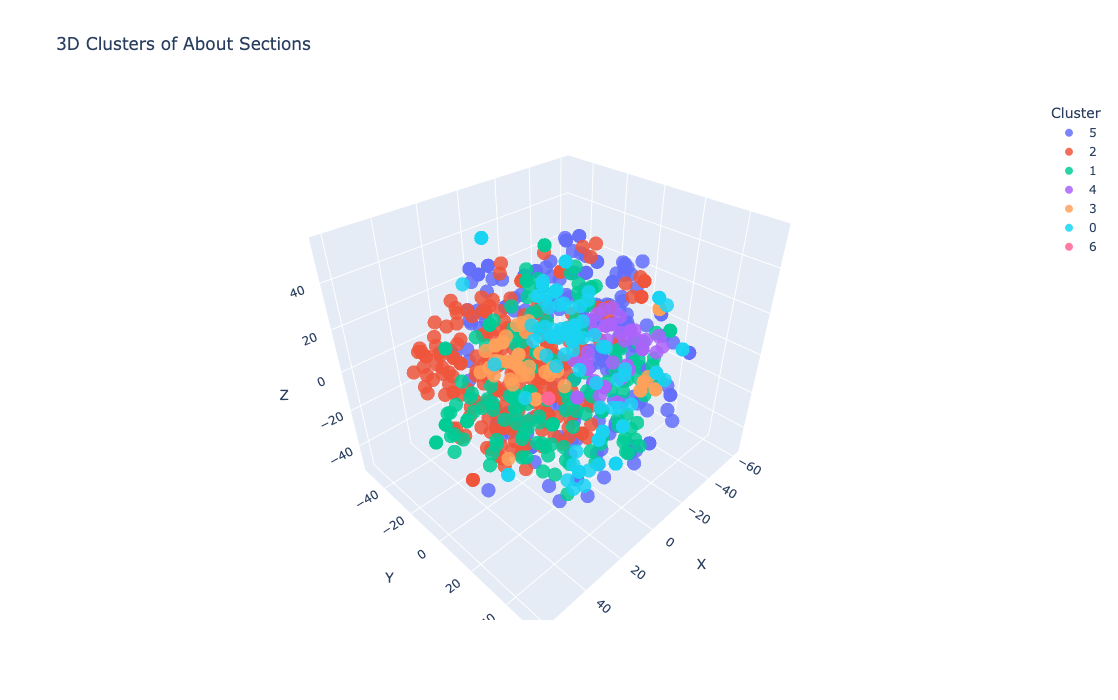

In [53]:
def plot_about_clusters(about, about_v_3d, labels):
    about_v_3d = np.asarray(about_v_3d)
    labels = np.asarray(labels)

    # Build tooltip text (first 20 words)
    hover_text = [
        " ".join(text.split()[:20]) + ("…" if len(text.split()) > 20 else "")
        for text in about
    ]

    df = pd.DataFrame({
        "x": about_v_3d[:, 0],
        "y": about_v_3d[:, 1],
        "z": about_v_3d[:, 2],
        "cluster": labels.astype(str),
        "hover": hover_text
    })

    # Rename noise label if present
    df.loc[df["cluster"] == "-1", "cluster"] = "noise"

    fig = px.scatter_3d(
        df,
        x="x",
        y="y",
        z="z",
        color="cluster",
        hover_data={"hover": True, "x": False, "y": False, "z": False},
        opacity=0.85,
        title="3D Clusters of About Sections"
    )

    fig.update_layout(
        legend_title_text="Cluster",
        height=700,
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        )
    )

    fig.show()
    fig.write_html("about_clusters.html")
    
plot_about_clusters(about, about_v_3d, labels)

### Summarize each group

In [578]:
from collections import defaultdict
import subprocess
import math
from tqdm import tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [69]:
skills = []

for d in data:
    skills.extend(d["skills"])

skills = pd.Series(skills)
counts = skills.value_counts()
counts[:30]

Python              526
Computer_Science    462
Java                380
CI                  347
CD                  346
AWS                 341
AI                  316
SQL                 280
React               264
Kubernetes          247
Agile               239
JavaScript          222
Azure               202
APIs                193
Engineering         191
C++                 187
We                  177
Docker              176
ML                  164
DevOps              162
C#                  154
TypeScript          142
API                 141
You                 137
Git                 129
Angular             124
Terraform           118
NoSQL               113
Linux               112
GCP                 111
Name: count, dtype: int64

In [74]:
import matplotlib.pyplot as plt
import logging
plt.xkcd()
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

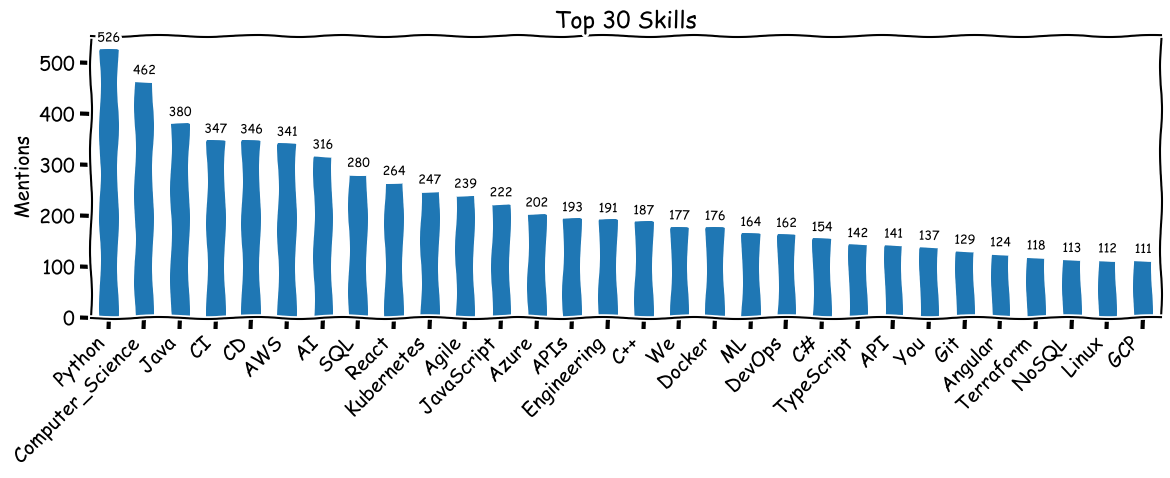

In [80]:
fig, ax = plt.subplots(figsize=(12, 5))

with plt.xkcd():
    counts[:30].plot(kind="bar", ax=ax)

    ax.set_ylabel("Mentions")
    ax.set_title("Top 30 Skills")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Add labels on bars
    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())),
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=9,
            xytext=(0, 3),
            textcoords="offset points"
        )

    plt.tight_layout()

plt.savefig("skills.png", dpi=300, bbox_inches="tight")
plt.show()

## Use transformer

In [635]:
from transformers import pipeline, AutoTokenizer
import random

In [624]:
MODEL_NAME = "sshleifer/distilbart-cnn-12-6"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

summarizer = pipeline(
    "summarization",
    model=MODEL_NAME,
    tokenizer=tokenizer
)

def chunk_text_by_tokens(text, tokenizer, max_tokens=900):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    return [
        tokenizer.decode(tokens[i:i + max_tokens], skip_special_tokens=True)
        for i in range(0, len(tokens), max_tokens)
    ]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [653]:
def summarize_text_safe(
    text,
    tokenizer,
    summarizer,
    max_tokens=900,
    max_length=400,
    min_length=150
):
    # Step 1: chunk original text
    chunks = chunk_text_by_tokens(text, tokenizer, max_tokens)
    summaries = []

    for chunk in tqdm(chunks, desc="Summarizing chunks", leave=False):
        result = summarizer(
            chunk,
            max_length=max_length,
            min_length=min_length,
            do_sample=False
        )
        summaries.append(result[0]["summary_text"])

    # Step 2: if combined summaries are still too large, recurse
    combined = " ".join(summaries)
    combined_tokens = len(tokenizer.encode(combined, add_special_tokens=False))

    if combined_tokens > max_tokens:
        # 🔁 recursively summarize summaries
        return summarize_text_safe(
            combined,
            tokenizer,
            summarizer,
            max_tokens=max_tokens,
            max_length=max_length,
            min_length=min_length
        )

    # Step 3: final safe summary
    final = summarizer(
        combined,
        max_length=max_length,
        min_length=min_length,
        do_sample=False
    )

    return final[0]["summary_text"]

In [654]:
def summarize_groups_with_transformers(grouped, tokenizer=tokenizer, summarizer=summarizer):
    summaries = {}

    for label, texts in tqdm(grouped.items(), desc="Summarizing clusters"):
        combined = " ".join(texts)
        summaries[label] = summarize_text_safe(
            combined,
            tokenizer,
            summarizer
        )

    return summaries

In [ ]:
grouped = group_by_labels(about, labels)

summaries = summarize_groups_with_transformers(grouped)

for label, summary in summaries.items():
    print(f"Cluster {label}: {summary}\n")

In [ ]:
def summarize_grouped_dict(grouped, sample_size=20):
    for label, texts in tqdm(grouped.items(), desc="Summarizing groups"):
        if not texts:
            continue

        sampled = random.sample(texts, min(sample_size, len(texts)))
        combined_text = " ".join(sampled)

        summary = summarize_text_safe(
            combined_text,
            tokenizer,
            summarizer
        )

        print(f"\n=== Group: {label} (sampled {len(sampled)} texts) ===")
        print(summary)

In [656]:
summarize_grouped_dict(grouped)

Summarizing groups:  14%|███▌                     | 1/7 [00:37<03:42, 37.13s/it]


=== Group: 5 (sampled 20 texts) ===
 Capella Space is a pioneer in Synthetic Aperture Radar (SAR) satellite technology and space-based signal intelligence . Capella is charting the future of Earth observation . InVita Healthcare Technologies is a leading software provider for complex medical, forensics, and community care environments . The posting will remain active until the position is filled, or a qualified pool of candidates is identified . The South Carolina Law Enforcement Division (SLED) is a premier statewide law enforcement agency dedicated to serving and protecting the citizens of South Carolina . The position will remain open for up to five days, with the posting being posted for as many as five days . BAE Systems, Inc. is an equal opportunity employer and will consider all applications without regard to race, sex, age, color,



Summarizing chunks:  86%|█████████████████████▍   | 6/7 [00:39<00:06,  6.57s/it]Your max_length is set to 400, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)

Summarizing chunks: 100%|█████████████████████████| 7/7 [00:45<00:00,  6.16s/it]
                                                                                
Summarizing chunks:  50%|████████████▌            | 1/2 [00:07<00:07,  7.33s/it]Your max_length is set to 400, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)

Summarizing chunks: 100%|█████████████████████████| 2/2 [00:12<00:00,  6.34s/it]
                                                                                Your max_lengt


=== Group: 2 (sampled 20 texts) ===
 The US base salary range for this full-time position is $113,000-$161,000 . The ERP Application Product Specialist will be responsible for managing our Vista and Vista Web systems . Netflix is looking for engineers who bring fresh ideas from all areas, including information retrieval, distributed computing,. large-scale system design, networking and data storage,. natural language processing, UI design and mobile . The SWT Team builds internal tooling that builds how our developers build, maintain, and test Netflix products . You’re not just writing backend code, you're building a product experience you believe in . You're passionate about observability, reliability, performance and ensuring these are understood by everyone on the team as it relates to our backend systems .



Summarizing chunks:  88%|█████████████████████▉   | 7/8 [00:47<00:06,  6.64s/it]Your max_length is set to 400, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)

Summarizing chunks: 100%|█████████████████████████| 8/8 [00:52<00:00,  6.21s/it]
                                                                                
Summarizing chunks:  50%|████████████▌            | 1/2 [00:06<00:06,  6.54s/it]Your max_length is set to 400, but your input_length is only 316. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=158)

Summarizing chunks: 100%|█████████████████████████| 2/2 [00:12<00:00,  6.05s/it]
                                                                                Your max_lengt


=== Group: 1 (sampled 20 texts) ===
 The Product Engineering Intern will join Lumafield’s Product team to prototype and ship experimental software that brings 3D data to life . The ByteDance Doubao (Seed) Team, is dedicated to pioneering advanced AI foundation models . The salary range listed and paragraph are only applicable to U.S.-based candidates . The position will be performed alongside a cohort of summer interns and is a paid position . We do not currently offer visa sponsorship or OPT eligibility . We encourage you to apply anyway – If you're excited about our technology, the opportunity, and are eager to learn more we’d love to hear from you! Etched  Ergo turns every customer conversation—across Zoom, email, Slack, and phone



Summarizing chunks: 100%|█████████████████████████| 6/6 [00:41<00:00,  7.01s/it]
                                                                                
Summarizing chunks:  50%|████████████▌            | 1/2 [00:06<00:06,  6.80s/it]Your max_length is set to 400, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)

Summarizing chunks: 100%|█████████████████████████| 2/2 [00:11<00:00,  5.84s/it]
                                                                                Your max_length is set to 400, but your input_length is only 308. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=154)
Summarizing groups:  57%|██████████████▎          | 4/7 [03:50<03:00, 60.11s/it]


=== Group: 4 (sampled 20 texts) ===
 Medtronic will consider for employment qualified job applicants with arrest or conviction records in accordance with the Los Angeles County Fair Chance Ordinance for Employers and the California Fair Chance Act . Cintel, Inc. expressly prohibits any form of unlawful employee harassment or discrimination based on any of the characteristics mentioned above . Alaska is not a state, but a state or state, or state of the United States, with jurisdiction in Washington DC or Alaska . Puerto Rico is one of the U.S. Virgin Islands and Alaska is a state of origin in the state of Washington, D.C., Alaska, Alaska, New England, Delaware and Delaware . The state of Puerto Rico has jurisdiction in Puerto Rico, Alaska and Hawaii . The U.N. has jurisdiction for Puerto



Summarizing chunks:  86%|█████████████████████▍   | 6/7 [00:42<00:07,  7.22s/it]Your max_length is set to 400, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)

Summarizing chunks: 100%|█████████████████████████| 7/7 [00:48<00:00,  6.66s/it]
                                                                                
Summarizing chunks:  50%|████████████▌            | 1/2 [00:07<00:07,  7.16s/it]Your max_length is set to 400, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)

Summarizing chunks: 100%|█████████████████████████| 2/2 [00:13<00:00,  6.39s/it]
                                                                                Your max_length


=== Group: 3 (sampled 20 texts) ===
 As a Data Engineer, you will monitor the measurement, audience and data products by developing Key Performance Indicators (KPIs), data pipelines, dashboards, and doing ad-hoc analysis to derive insights and opportunities . SRC offers a generous benefit package, including medical, dental, vision, 401(k) with a company match, life insurance, vacation and sick paid time off accruals starting at 10 days of vacation and 5 days of sick leave annually, 11 paid holidays, tuition reimbursement, and tuition reimbursement . Netflix has a unique culture and environment. We do not discriminate on the basis of race, religion, color, . For more information: http://www.dailymailonline.com/news/business//



Summarizing groups:  86%|█████████████████████▍   | 6/7 [05:39<00:55, 55.65s/it]


=== Group: 0 (sampled 20 texts) ===
 Akraya is an award-winning IT staffing firm consistently recognized for its commitment to excellence and a thriving work environment . At Ford Motor Company, we believe freedom of movement drives human progress . At Scribd (pronounced “scribbed”), our mission is to spark human curiosity . At Sherwin-Williams, our purpose is to inspire and improve the world by coloring and protecting what matters . At Recidiviz is creating safer, healthier communities by improving outcomes for people in the criminal justice system . At Gusto, we're on a mission to grow the small business economy . At Bridge, we offer "Culture Conversations Conversations" to help you gain insights into our culture . All your information will be kept confidential according to EEO guidelines .



Summarizing chunks: 100%|█████████████████████████| 1/1 [00:06<00:00,  6.29s/it]
                                                                                Your max_length is set to 400, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)
Summarizing groups: 100%|█████████████████████████| 7/7 [05:51<00:00, 50.19s/it]


=== Group: 6 (sampled 13 texts) ===
 The group says they embrace responsibility to change the way the world is now and that it will be better for all in the future . They say they want the change to be more equitable, safe and for the future of all of the world . We want to lead change that makes our world safer, safer, more equitable and more for all, not just for the sake of all, but for the benefit of all . Our vision is a world with Zero Crashes, Zero Emissions and Zero Congestion and we embrace the responsibility to lead the change that will make our world better, safer and more equitable for all . We embrace responsibility for the change we want to make the world better and safer for all for all. We are committed to leading


## Key Phrases About Experience

In [54]:
key_phrases_exp = []
for d in data:
    if len(d["key_phrases_exp"]) != 0:
        key_phrases_exp.extend(d["key_phrases_exp"])

len(key_phrases_exp)

14983

In [59]:
embeddings = model.encode(key_phrases_exp, normalize_embeddings=True)
n_clusters = 7  # adjust as needed

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

In [60]:
tsne = TSNE(
    n_components=3,
    perplexity=min(5, len(embeddings) - 1),
    random_state=42,
    init="random"
)

embeddings_3d = tsne.fit_transform(embeddings)

In [61]:
df = pd.DataFrame({
    "x": embeddings_3d[:, 0],
    "y": embeddings_3d[:, 1],
    "z": embeddings_3d[:, 2],
    "label": labels,
    "phrase": key_phrases_exp
})

MAX_PER_CLUSTER = 200

df_sampled = (
    df.groupby("label", group_keys=False)
      .apply(lambda g: g.sample(
          n=min(len(g), MAX_PER_CLUSTER),
          random_state=42
      ))
      .reset_index(drop=True)
)

/var/folders/fk/rw9x_v3x22q1nbw6f2q5t0g40000gn/T/ipykernel_5836/1458634367.py:13: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



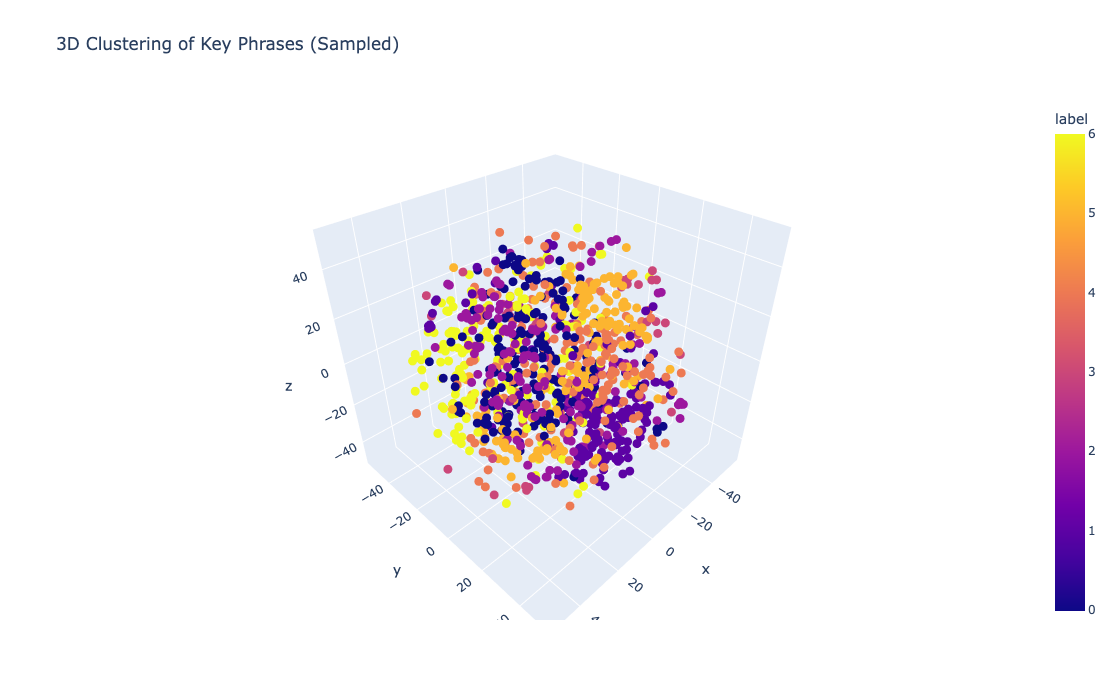

In [62]:
fig = px.scatter_3d(
    df_sampled,
    x="x",
    y="y",
    z="z",
    color="label",
    hover_data=["phrase"],
    title="3D Clustering of Key Phrases (Sampled)"
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(height=700)
fig.show()
fig.write_html("key_phrases_clusters.html")

## Benefits

In [63]:
benefits = []

for d in data:
    if len(d["benefits"]) != 0:
        benefits.extend(d["benefits"])

len(benefits)

1766

In [64]:
embeddings = model.encode(benefits, normalize_embeddings=True)
n_clusters = 5  # adjust as needed

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

In [65]:
tsne = TSNE(
    n_components=3,
    perplexity=min(5, len(embeddings) - 1),
    random_state=42,
    init="random"
)

embeddings_3d = tsne.fit_transform(embeddings)

In [66]:
df = pd.DataFrame({
    "x": embeddings_3d[:, 0],
    "y": embeddings_3d[:, 1],
    "z": embeddings_3d[:, 2],
    "label": labels,
    "phrase": benefits
})

MAX_PER_CLUSTER = 200

df_sampled = (
    df.groupby("label", group_keys=False)
      .apply(lambda g: g.sample(
          n=min(len(g), MAX_PER_CLUSTER),
          random_state=42
      ))
      .reset_index(drop=True)
)

/var/folders/fk/rw9x_v3x22q1nbw6f2q5t0g40000gn/T/ipykernel_5836/1533034696.py:13: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



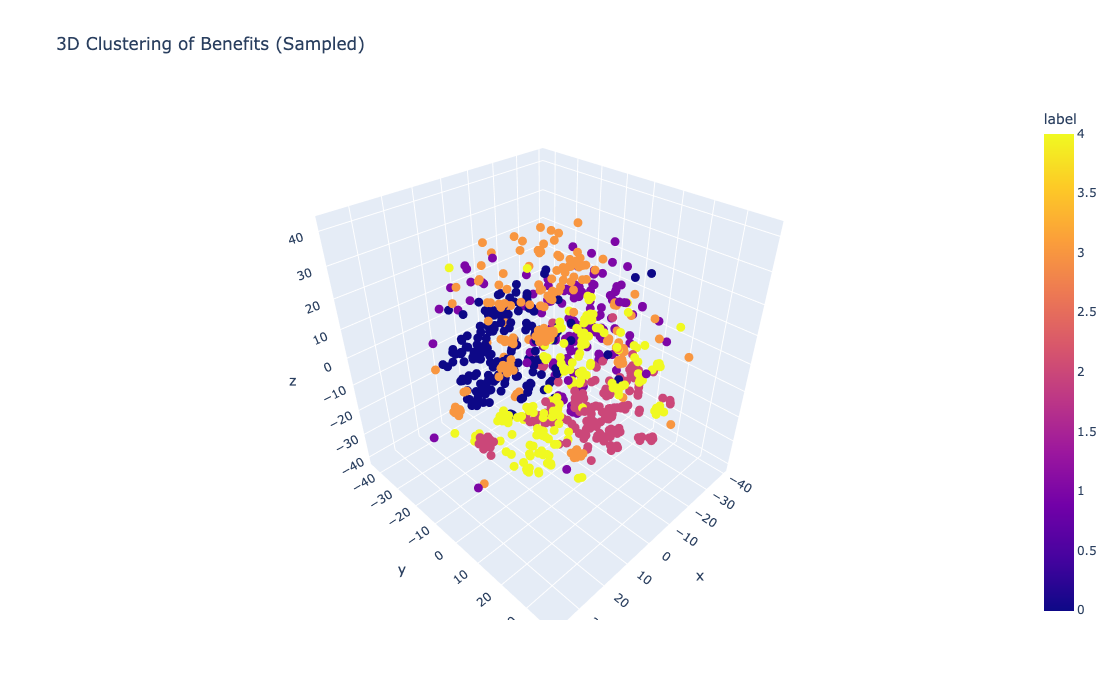

In [67]:
fig = px.scatter_3d(
    df_sampled,
    x="x",
    y="y",
    z="z",
    color="label",
    hover_data=["phrase"],
    title="3D Clustering of Benefits (Sampled)"
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(height=700)
fig.show()
fig.write_html("benefits_clusters.html")

## Title

In [45]:
titles = jobs.title
titles.value_counts()[:10]

title
Software Engineer                 229
Senior Software Engineer           49
Data Engineer                      34
Full Stack Engineer                29
Full Stack Developer               27
Software Developer                 26
Integration Solutions Engineer     26
DevOps Engineer                    22
Integration Project Engineer       21
Technical Solutions Engineer       21
Name: count, dtype: int64

## Logo (optional - another time?)

### Appendix 1: data aggregation and a list of cities covered by the dataset

**Table 1.** A list of files and corresponding city, states and number of jobs found

| #  | file name               | city                     | number of jobs found |
|----|--------------------------|--------------------------|-------------------------|
| 1  | jobs_AL.csv             | Birmingham, AL           | 30  |
| 2  | jobs_ALMontgomery.csv   | Montgomery, AL           | 19  |
| 3  | jobs_AZPheonix.csv      | Phoenix, AZ              | 70  |
| 4  | jobs_AZTucson.csv       | Tucson, AZ               | 30  |
| 5  | jobs_Boston.csv         | Boston, MA               | 140 |
| 6  | jobs_CASD.csv           | San Diego, CA            | 90  |
| 7  | jobs_CASacramento.csv   | Sacramento, CA           | 140 |
| 8  | jobs_CO.csv             | Denver, CO               | 140 |
| 9  | jobs_CT.csv             | Hartford, CT             | 70  |
| 10 | jobs_DC.csv             | Washington D.C., D.C.    | 138 |
| 11 | jobs_GA.csv             | Atlanta, GA              | 120 |
| 12 | jobs_GASavannah.csv     | Savannah, GA             | 4   |
| 13 | jobs_IA.csv             | Des Moines, IA           | 38  |
| 14 | jobs_IN.csv             | Indianapolis, IN         | 60  |
| 15 | jobs_INChicago.csv      | Chicago, IN              | 119 |
| 16 | jobs_KY.csv             | Louisville, KY           | 33  |
| 17 | jobs_LA.csv             | New Orleans, LA          | 21  |
| 18 | jobs_MD.csv             | Baltimore, MD            | 139 |
| 19 | jobs_MI.csv             | Detroit, MI              | 80  |
| 20 | jobs_MN.csv             | Minneapolis, MN          | 75  |
| 21 | jobs_MO.csv             | St Louis, MO             | 60  |
| 22 | jobs_MOKC.csv           | Kansas City, MO          | 56  |
| 23 | jobs_MS.csv             | Jackson, MS              | 24  |
| 24 | jobs_NC.csv             | Raleigh, NC              | 90  |
| 25 | jobs_NCCharlotte.csv    | Charlotte, NC            | 89  |
| 26 | jobs_NM.csv             | Santa Fe, NM             | 14  |
| 27 | jobs_NMAlbuquerque.csv  | Albuquerque, NM          | 28  |
| 28 | jobs_NY.csv             | New York, NY             | 140 |
| 29 | jobs_OH.csv             | Cincinnati, OH           | 70  |
| 30 | jobs_OHCleveland.csv    | Cleveland, OH            | 50  |
| 31 | jobs_OK.csv             | Oklahoma City, OK        | 30  |
| 32 | jobs_OR.csv             | Portland, OR             | 60  |
| 33 | jobs_PA.csv             | Pittsburgh, PA           | 69  |
| 34 | jobs_SC.csv             | Charleston, SC           | 30  |
| 35 | jobs_SCColumbia.csv     | Columbia, SC             | 30  |
| 36 | jobs_SF.csv             | San Francisco, CA        | 140 |
| 37 | jobs_SanJose.csv        | San Jose, CA             | 140 |
| 38 | jobs_Seattle.csv        | Seattle, CA              | 140 |
| 39 | jobs_TN.csv             | Memphis, TN              | 27  |
| 40 | jobs_UT.csv             | Salt Lake City, UT       | 70  |
| 41 | jobs_VA.csv             | Richmond, VA             | 60  |
| 42 | jobs_WI.csv             | Milwaukee, WI            | 57  |
| 43 | jobs_WIMadison.csv      | Madison, WI              | 30  |
|    | **TOTAL**               | —                        | **3060** |

### Aggregating backend engineering jobs

In [176]:
root_dir = "data/"
job_dir_backend_eng = "backend_engineer/"
job_dir_ds = "data_scientist/"
files = os.listdir(root_dir + job_dir_backend_eng)
print(files), len(files)

['jobs_PA.csv', 'jobs_IA.csv', 'jobs_Boston.csv', 'jobs_DC.csv', '.DS_Store', 'jobs_NMAlbuquerque.csv', 'jobs_Seattle.csv', 'jobs_KY.csv', 'jobs_MI.csv', 'jobs_CT.csv', 'jobs_NCCharlotte.csv', 'jobs_VA.csv', 'jobs_SanJose.csv', 'jobs_AL.csv', 'jobs_NC.csv', 'jobs_MO.csv', 'jobs_MN.csv', 'jobs_AZTucson.csv', 'jobs_TN.csv', 'jobs_OR.csv', 'jobs_CASD.csv', 'jobs_OH.csv', 'jobs_NM.csv', 'jobs_GASavannah.csv', 'jobs_INChicago.csv', 'jobs_OK.csv', 'jobs_NY.csv', 'jobs_ALMontgomery.csv', 'jobs_MOKC.csv', 'jobs_WI.csv', 'jobs_WIMadison.csv', 'jobs_OHCleveland.csv', 'jobs_UT.csv', 'jobs_LA.csv', 'jobs_MS.csv', 'jobs_MD.csv', 'jobs_CO.csv', 'jobs_GA.csv', 'jobs_CASacramento.csv', 'jobs_SF.csv', 'jobs_SCColumbia.csv', 'jobs_AZPheonix.csv', 'jobs_SC.csv', 'jobs_IN.csv']


(None, 44)

In [177]:
# Dictionary mapping filenames to city (area)
csv2area = {
    "jobs_AL.csv": "Birmingham, AL",
    "jobs_ALMontgomery.csv": "Montgomery, AL",
    "jobs_AZPheonix.csv": "Phoenix, AZ",
    "jobs_AZTucson.csv": "Tucson, AZ",
    "jobs_Boston.csv": "Boston, MA",
    "jobs_CASD.csv": "San Diego, CA",
    "jobs_CASacramento.csv": "Sacramento, CA",
    "jobs_CO.csv": "Denver, CO",
    "jobs_CT.csv": "Hartford, CT",
    "jobs_DC.csv": "Washington D.C., D.C.",
    "jobs_GA.csv": "Atlanta, GA",
    "jobs_GASavannah.csv": "Savannah, GA",
    "jobs_IA.csv": "Des Moines, IA",
    "jobs_IN.csv": "Indianapolis, IN",
    "jobs_INChicago.csv": "Chicago, IN",
    "jobs_KY.csv": "Louisville, KY",
    "jobs_LA.csv": "New Orleans, LA",
    "jobs_MD.csv": "Baltimore, MD",
    "jobs_MI.csv": "Detroit, MI",
    "jobs_MN.csv": "Minneapolis, MN",
    "jobs_MO.csv": "St Louis, MO",
    "jobs_MOKC.csv": "Kansas City, MO",
    "jobs_MS.csv": "Jackson, MS",
    "jobs_NC.csv": "Raleigh, NC",
    "jobs_NCCharlotte.csv": "Charlotte, NC",
    "jobs_NM.csv": "Santa Fe, NM",
    "jobs_NMAlbuquerque.csv": "Albuquerque, NM",
    "jobs_NY.csv": "New York, NY",
    "jobs_OH.csv": "Cincinnati, OH",
    "jobs_OHCleveland.csv": "Cleveland, OH",
    "jobs_OK.csv": "Oklahoma City, OK",
    "jobs_OR.csv": "Portland, OR",
    "jobs_PA.csv": "Pittsburgh, PA",
    "jobs_SC.csv": "North Charleston, SC",
    "jobs_SCColumbia.csv": "Columbia, SC",
    "jobs_SF.csv": "San Francisco, CA",
    "jobs_SanJose.csv": "San Jose, CA",
    "jobs_Seattle.csv": "Seattle, CA",
    "jobs_TN.csv": "Memphis, TN",
    "jobs_UT.csv": "Salt Lake City, UT",
    "jobs_VA.csv": "Richmond, VA",
    "jobs_WI.csv": "Milwaukee, WI",
    "jobs_WIMadison.csv": "Madison, WI",
}

# List of filenames to iterate through
# Example: files = list(csv2area.keys())
files = list(csv2area.keys())

all_jobs = []   # to collect all dataframes

for file in files:
    jobs = pd.read_csv(root_dir+job_dir_backend_eng+file)          # load CSV
    jobs["area"] = csv2area[file]     # assign area
    if "location" in jobs.columns:
        cols = list(jobs.columns)
        cols.remove("area")
        loc_index = cols.index("location") + 1
        cols.insert(loc_index, "area")
        jobs = jobs[cols]
    all_jobs.append(jobs)             # store df

# Stack/aggregate all dataframes
df = pd.concat(all_jobs, ignore_index=True)

# Save aggregated file
df.to_csv("jobs.csv", index=False)

In [178]:
jobs = pd.read_csv(root_dir+"jobs.csv")

In [179]:
jobs.head()

,id,site,job_url,job_url_direct,title,company,location,area,date_posted,job_type,...,company_addresses,company_num_employees,company_revenue,company_description,skills,experience_range,company_rating,company_reviews_count,vacancy_count,work_from_home_type
0,li-4323516725,linkedin,https://www.linkedin.com/jobs/view/4323516725,NaN,Junior Software Engineer,Brooksource,"Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,li-4333159993,linkedin,https://www.linkedin.com/jobs/view/4333159993,https://shipt.wd1.myworkdayjobs.com/Shipt_Exte...,Senior Engineer,Shipt,"Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,li-4256077277,linkedin,https://www.linkedin.com/jobs/view/4256077277,https://industrycareers-enercon.icims.com/jobs...,Physical Security Engineer,"Enercon Services, Inc.","Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,li-4338291784,linkedin,https://www.linkedin.com/jobs/view/4338291784,NaN,Distinguished Engineer - AI Infrastructure Arc...,Cisco,"Birmingham, AL","Birmingham, AL",2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,li-4302046287,linkedin,https://www.linkedin.com/jobs/view/4302046287,NaN,Information Services Quality Assurance Interns...,Altec,"Birmingham, AL","Birmingham, AL",2025-11-21,internship,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Aggregating sampled data scientist jobs in comparison

This aggregation builds a dataset of sampled 836 data scientist jobs from SF, LA, Seattle, San Jose, New York and Denver to be compared to the aggregated backend engineering dataset.

In [180]:
jobs_ds = pd.read_csv(root_dir+"jobs_ds.csv")
jobs_ds.head()

,id,site,job_url,job_url_direct,title,company,location,area,date_posted,job_type,...,company_addresses,company_num_employees,company_revenue,company_description,skills,experience_range,company_rating,company_reviews_count,vacancy_count,work_from_home_type
0,li-4290341003,linkedin,https://www.linkedin.com/jobs/view/4290341003,https://www.samsara.com/company/careers/roles/...,(New Grad) Software Engineering,Samsara,"San Francisco, CA",Seattle,2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,li-4338221974,linkedin,https://www.linkedin.com/jobs/view/4338221974,NaN,"Software Engineer, Bridge",Stripe,"San Francisco, CA",Seattle,2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,li-4333322957,linkedin,https://www.linkedin.com/jobs/view/4333322957,NaN,Full Stack Engineer,Adobe,"San Jose, CA",Seattle,2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,li-4337602941,linkedin,https://www.linkedin.com/jobs/view/4337602941,https://dsp.prng.co/1pYV21b&urlHash=bseg,Software Engineer 2,Intuit,"Mountain View, CA",Seattle,2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,li-4338372388,linkedin,https://www.linkedin.com/jobs/view/4338372388,https://dsp.prng.co/sqakw3b&urlHash=7Bda,"Software Engineer I, Virtual Expert Platform (...",Intuit,"Mountain View, CA",Seattle,2025-11-21,fulltime,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
jobs_ds.shape

(834, 35)